In [1]:
!pip install pillow

    100% |████████████████████████████████| 2.0MB 680kB/s eta 0:00:01
You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.preprocessing import image
from keras.utils.np_utils import to_categorical
import numpy as np
#from sklearn.preprocessing import LabelEncoder
from keras.optimizers import Adam
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Dropout, Flatten, merge, Reshape, Activation

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
import PIL
import PIL.Image

In [3]:
#!pip install pillow,scikit-learn
#import PIL,sklearn
import glob,matplotlib as plt
%matplotlib inline

In [4]:
from keras.applications.vgg16 import VGG16, preprocess_input,decode_predictions

In [4]:
#from keras.applications.resnet50 import ResNet50,preprocess_input, decode_predictions

In [5]:
img_width, img_height = 224, 224

In [6]:
model = applications.VGG16(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))

In [6]:
l=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [7]:
path='train/'
img_train=[]
for i in l:
    img_list = glob.glob(path+str(i)+'**/*.jpg', recursive=True)
    img_train +=img_list
    
path='test/'
img_test= glob.glob(path+'**/*.jpg', recursive=True)
    

In [9]:
len(img_train),len(img_test)

(76505, 21273)

In [8]:
import pandas as pd

In [11]:
label=pd.DataFrame()
label['id']=img_train
label['target']=label.id.apply(lambda x : x.split("/")[1])
#label['id']=label.id.apply(lambda x : x.split("/")[2])


In [12]:
label.drop_duplicates(keep='first',inplace=True)

In [13]:
!pip install sklearn
from sklearn.utils import shuffle
#

    100% |████████████████████████████████| 12.4MB 111kB/s eta 0:00:01
  Running setup.py bdist_wheel for sklearn ... done
  Stored in directory: /home/ubuntu/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn
You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [15]:
label = shuffle(label)
label.head()

,id,target
22999,train/2/n03630383_968_1.jpg,2
16564,train/1/n04186455_15935_0.jpg,1
27871,train/2/n03057021_8042_0.jpg,2
12822,train/13/n02811719_6719_0.jpg,13
48459,train/6/n02807616_4434_0.jpg,6


In [9]:

import cv2

def read_image(img_path,H,W):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (W,H)) # you can resize to  (128,128) or (256,256)
    return img


In [10]:
import gc
gc.collect()

11

In [18]:
%%time
image_lr=[]
train_img=[]
for i in list(label.id):
    image_lr.append(read_image(i,224,224))
train_img=np.array(image_lr,dtype=np.float32)
train_img=preprocess_input(train_img,mode='tf')

CPU times: user 1min 13s, sys: 16.5 s, total: 1min 30s
Wall time: 1min 29s


In [11]:
%%time
image_lr=[]
test_img=[]
for i in img_test:
    image_lr.append(read_image(i,224,224))
test_img=np.array(image_lr,dtype=np.float32)
test_img=preprocess_input(test_img,mode='tf')

CPU times: user 24.4 s, sys: 6.04 s, total: 30.4 s
Wall time: 30.4 s


In [ ]:
train_img.shape#,test_img.shape

In [ ]:
'''
# Initiate the train and test generators with data Augumentation 
train_datagen = ImageDataGenerator(
#rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.2,
width_shift_range = 0.2,
height_shift_range=0.2,
rotation_range=20)

test_datagen = ImageDataGenerator(
#rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.2,
width_shift_range = 0.2,
height_shift_range=0.2,
rotation_range=20)
gc.collect()

'''

In [ ]:
#l=train_img.shape[0]-int(0.1*train_img.shape[0])
#l


In [19]:
from keras.utils import to_categorical
Y=to_categorical(label.target,num_classes=15)
Y.shape

(62258, 15)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


12


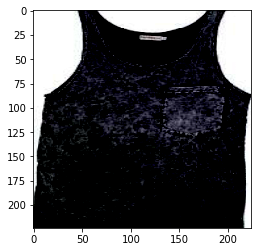

In [20]:
i=55910
print(np.argmax(Y[i]))
plt.pyplot.imshow(train_img[i])

In [ ]:
x_train=train_img[:l,:,:,:]
y_train=Y[:l]
x_valid=train_img[l:,:,:,:]
y_valid=Y[l:]

In [ ]:
x_train.shape,y_train.shape,x_valid.shape,y_valid.shape

In [ ]:
'''

train_generator = train_datagen.flow(x_train,y_train,
                                    batch_size = batch_size,
                                    shuffle=True)
                                    #class_mode = "categorical")

validation_generator = test_datagen.flow(x_valid,y_valid,
                                         batch_size = batch_size,
                                        shuffle=True)
                                        #class_mode = "categorical")

'''

In [ ]:
#model = applications.ResNet50(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))

In [21]:
model.layers[16:]

In [21]:
# Freeze the layers which you don't want to train. Here I am freezing the first 5 layers.
for layer in model.layers[:16]:
    layer.trainable = False
for layer in model.layers[16:]:
    layer.trainable = True
        

In [30]:


#Adding custom Layers 
x = model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(128, activation="relu")(x)
predictions = Dense(15, activation="softmax")(x)

# creating the final model 
model_final = Model(input = model.input, output = predictions)
#model.load_weights('caavo-1.h5')

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  if sys.path[0] == '':


In [ ]:

# Save the model according to the conditions  
#checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
#early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')


In [23]:
from keras.metrics import categorical_accuracy

In [31]:
adam = Adam(lr=1e-3)
model_final.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
model_final.fit(train_img, Y,batch_size=256,epochs=2,shuffle=True,verbose=1)

Epoch 1/2
62258/62258 [==============================] - 723s 12ms/step - loss: 1.4254 - acc: 0.5369
Epoch 2/2
62258/62258 [==============================] - 719s 12ms/step - loss: 1.2007 - acc: 0.6071


In [34]:
# Train the model 
k.set_value(adam.lr, 0.0001)

model_final.fit(train_img, Y,batch_size=256,epochs=3,shuffle=True,verbose=1)
#callbacks = [checkpoint, early])

Epoch 1/3
62258/62258 [==============================] - 719s 12ms/step - loss: 0.9726 - acc: 0.6840
Epoch 2/3
62258/62258 [==============================] - 720s 12ms/step - loss: 0.9134 - acc: 0.7046
Epoch 3/3
62258/62258 [==============================] - 719s 12ms/step - loss: 0.8671 - acc: 0.7190


In [35]:
# serialize model to JSON
from keras.models import model_from_json
model_json = model_final.to_json()
with open("caavo-1.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_final.save_weights("caavo-1.h5")
print("Saved model to disk")
 
# later...


Saved model to disk


### PREDICTIONG / SUBMISSION

##### LOAD MODEL AND WEIGHTS

In [12]:
# serialize model to JSON
from keras.models import model_from_json
# load json and create model
json_file = open('caavo-1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_final = model_from_json(loaded_model_json)
# load weights into new model
model_final.load_weights("caavo-1.h5")
print("Loaded model from disk")



Loaded model from disk


In [20]:
pred=model_final.predict(test_img, batch_size=128,verbose=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6


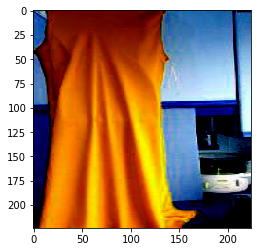

In [21]:
i=5200
print(np.argmax(pred[i]))
plt.pyplot.imshow(test_img[i])


In [22]:
p=[]
for i in range(test_img.shape[0]):
    p.append(np.argmax(pred[i]))

In [23]:
len(p)

21273

In [24]:
sub=pd.read_csv('sample_submissioin.csv')
sub.head()

,image_name,category
0,n02854926_10060_0.jpg,0
1,n02854926_10090_0.jpg,4
2,n02854926_10147_0.jpg,13
3,n02854926_10356_0.jpg,4
4,n02854926_10669_0.jpg,7


In [25]:
sub1=pd.DataFrame()
sub1['image_name']=img_test
sub1['image_name']=sub1['image_name'].apply(lambda x : x.split("/")[1])
sub1.head()

,image_name
0,n02780704_4270_0.jpg
1,n03978966_13641_0.jpg
2,n02943964_1584_0.jpg
3,n02807616_18714_0.jpg
4,n03404251_185_0.jpg


In [26]:
sub1['category']=p
sub1.to_csv('sub1.csv',index=False)
sub1.head()

,image_name,category
0,n02780704_4270_0.jpg,8
1,n03978966_13641_0.jpg,5
2,n02943964_1584_0.jpg,7
3,n02807616_18714_0.jpg,6
4,n03404251_185_0.jpg,2


In [27]:
sub1.category.value_counts()

4     3445
2     2734
3     2277
1     2184
9     1938
12    1764
6     1756
10    1663
8     1219
13    1071
11     350
7      326
0      217
5      193
14     136
Name: category, dtype: int64